# Exercices

## **Préliminaires**: Clone de votre repo et imports

In [1]:
# fonctions utiles pour l'ensemble des exercices:
! git clone https://github.com/Zakaria-Yahya/exam_2025_session2.git
! cp exam_2025_session2/utils/utils.py .
import copy
import numpy as np
import torch
import matplotlib.pyplot as plt
from utils import gen_dr, gen_d, gen_ex2, gen_dr_train,gen_dr_test, voir_batch2D, UNet, make_batch

Cloning into 'exam_2025_session2'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 81 (delta 23), reused 8 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (81/81), 312.73 KiB | 15.64 MiB/s, done.
Resolving deltas: 100% (23/23), done.


\

---

\

\

**Exercice 1** *Une segmentation dans un contexte faiblement supervisé*

La fonction *gen_dr* permet de synthétiser des disques mêlés à des rectangles. Ici, les disques sont considérés comme du bruit, et le processus de corruption non en une somme (image = image_disques + image_rectangles) mais en une substitution (voir ci-dessous).
Elle fournit aussi une cible idéale, qui, en pratique, n'est pas disponible.


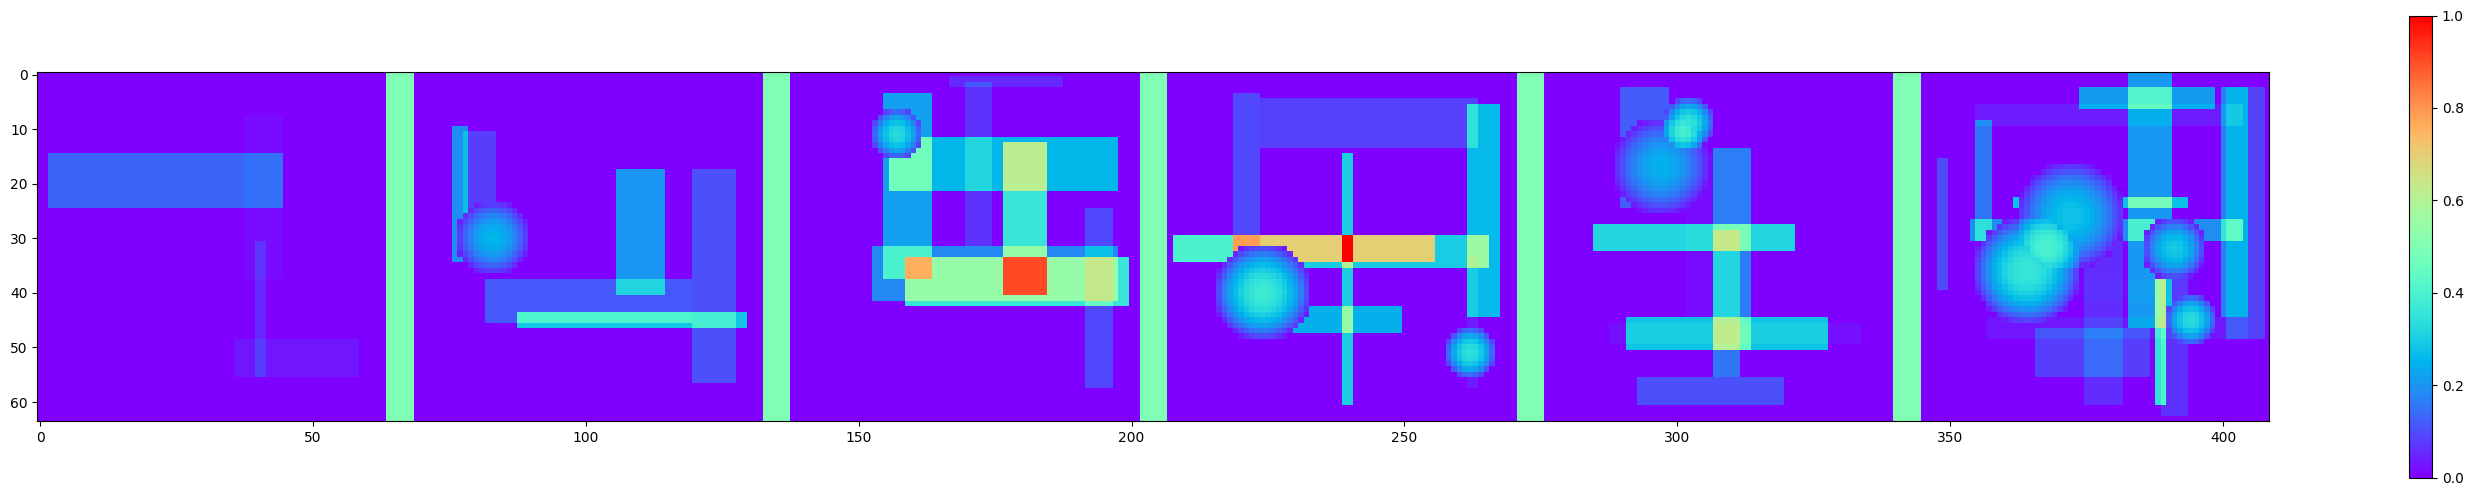

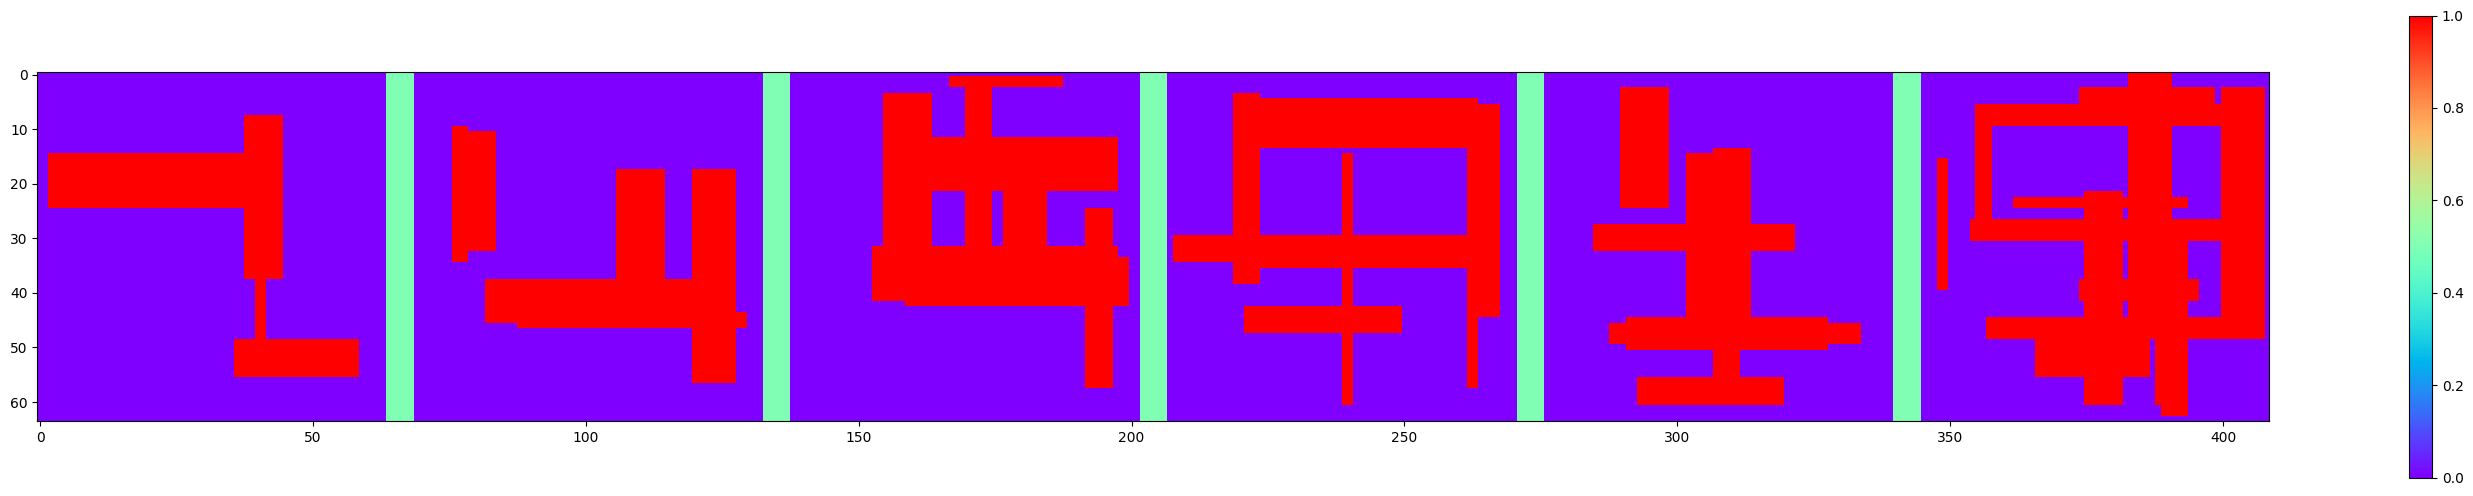

In [2]:
input, ideal_targets = gen_dr(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# ideal targets
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(ideal_targets, 6, fig1, k=0, min_scale=0,max_scale=1)

On dispose aussi d'une fonction *gen_d* qui synthétise des images comportant des disques :

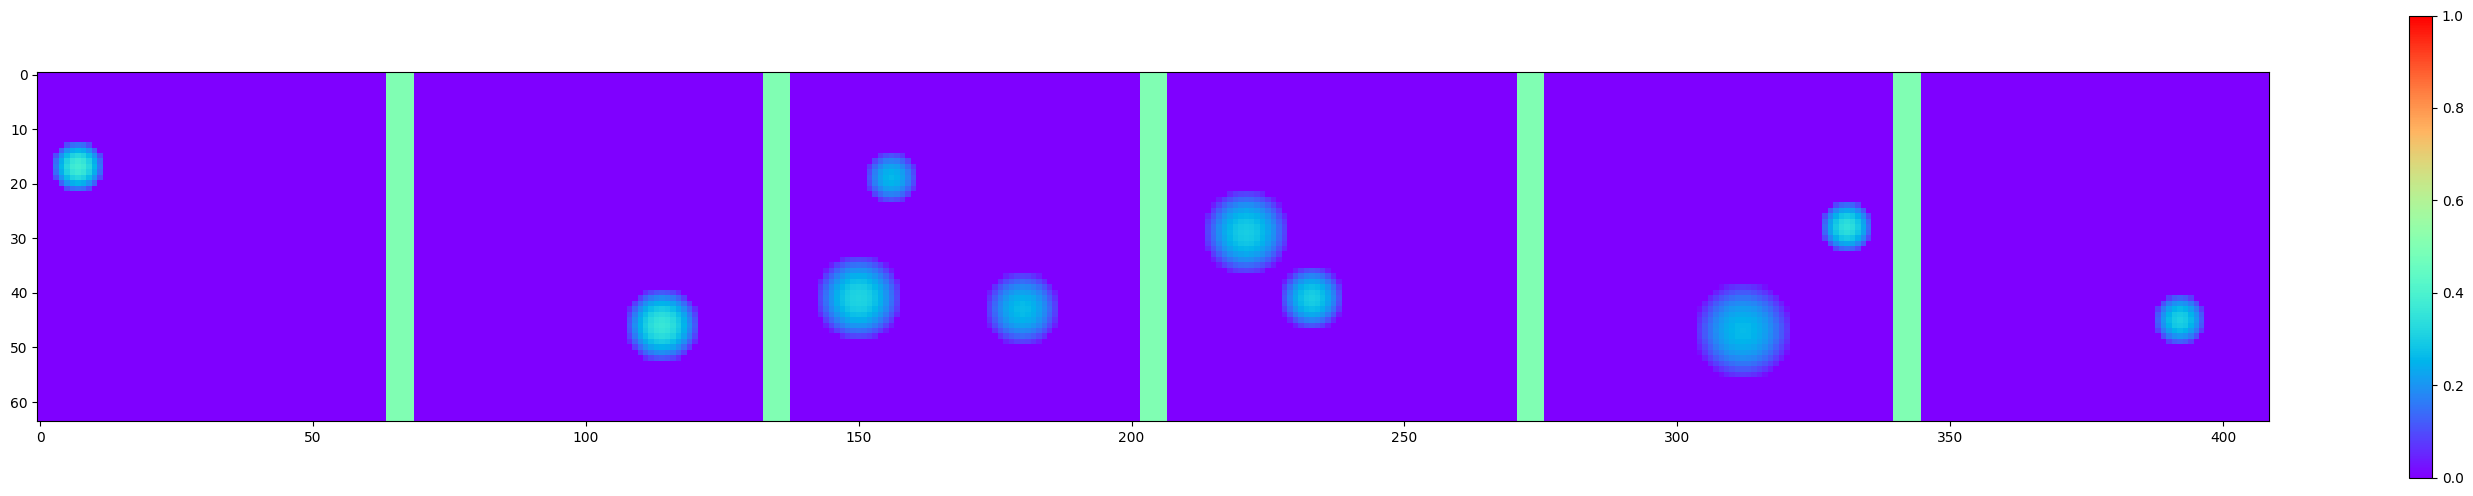

In [3]:
discs = gen_d(6)
# Discs
fig2 = plt.figure(0, figsize=(36, 6))
voir_batch2D(discs, 6, fig2, k=0, min_scale=0,max_scale=1)


**Q1** Rappeler ce qu'est la supervision faible. En quoi ce problème peut-il entrer dans cette catégorie ?

**Reponse:**
Supervision faible est quand le modèle est entraîné avec des données partiellement étiquetées.
Ce problème est considéré comme de la supervision faible car nous n'avons pas les cibles idéales pour toutes les images. On a seulement des images cibles pour un sous-ensemble des données d'entraînement. On doit donc utiliser une forme de supervision faible pour que le modèle puisse prédire l'emplacement des pixels de rectangles avant la corruption sur de nouvelles images.

**Q2** Utiliser un UNet pour dire, pour une image produite par gen_dr, où sont les pixels qui étaient affectés par des rectangles **avant** corruption. Entraînez-le sur une cinquantaine d'époques. Utilisez la cible idéale pour contrôler la convergence. Visualiser quelques sorties après entraînement. Commentez.

<ipython-input-32-528128b4a7ff>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(1).squeeze(2)  # Ajout d'une dimension de canal
<ipython-input-32-528128b4a7ff>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(ideal_targets, dtype=torch.float32).unsqueeze(1).squeeze(2)


Epoch 0/50, Loss: 0.7386
Epoch 10/50, Loss: 0.2395
Epoch 20/50, Loss: 0.1591
Epoch 30/50, Loss: 0.1149
Epoch 40/50, Loss: 0.0866


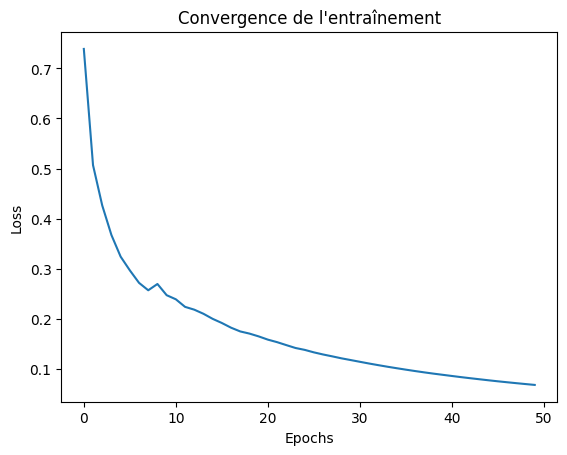

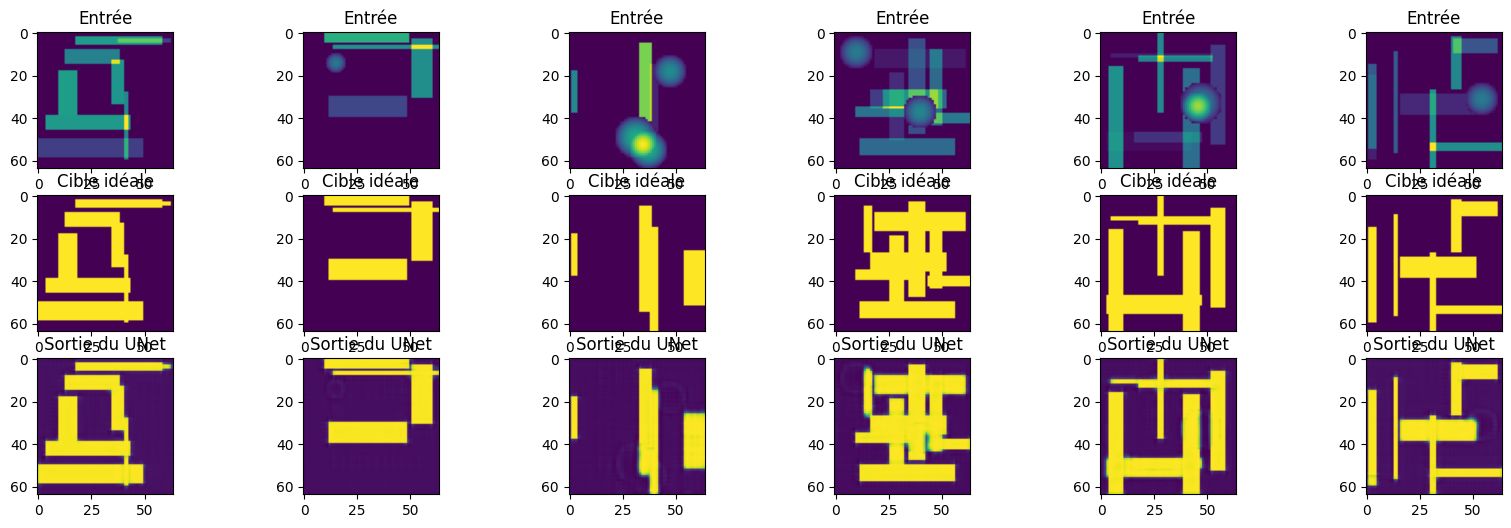

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


def train_unet(n_epochs=50, batch_size=6, lr=0.001):
    # Génération des données d'entraînement
    inputs, ideal_targets = gen_dr(batch_size)

    # Conversion en tenseurs PyTorch
    inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(1).squeeze(2)  # Ajout d'une dimension de canal
    targets = torch.tensor(ideal_targets, dtype=torch.float32).unsqueeze(1).squeeze(2)

    # Définition du modèle, de la fonction de perte et de l'optimiseur
    model = UNet(n_channels=1, n_classes=1)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []

    # Entraînement
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{n_epochs}, Loss: {loss.item():.4f}")

    # Visualisation de la perte
    plt.plot(losses)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Convergence de l'entraînement")
    plt.show()

    # Visualisation des résultats
    outputs = torch.sigmoid(model(inputs)).detach().numpy()

    fig, axes = plt.subplots(3, batch_size, figsize=(20, 6))
    for i in range(batch_size):
        axes[0, i].imshow(inputs[i, 0])
        axes[0, i].set_title("Entrée")

        axes[1, i].imshow(targets[i, 0])
        axes[1, i].set_title("Cible idéale")

        axes[2, i].imshow(outputs[i, 0])
        axes[2, i].set_title("Sortie du UNet")

    plt.show()
    return model

# Entraînement du modèle
model = train_unet()




\

**Exercice 2** *Une régression quantile*

La fonction *gen_ex2* permet de synthétiser des entrées / cibles à la volée :  




tensor([6.6827, 6.9251, 7.3349, 4.1914, 2.8756, 1.0660])


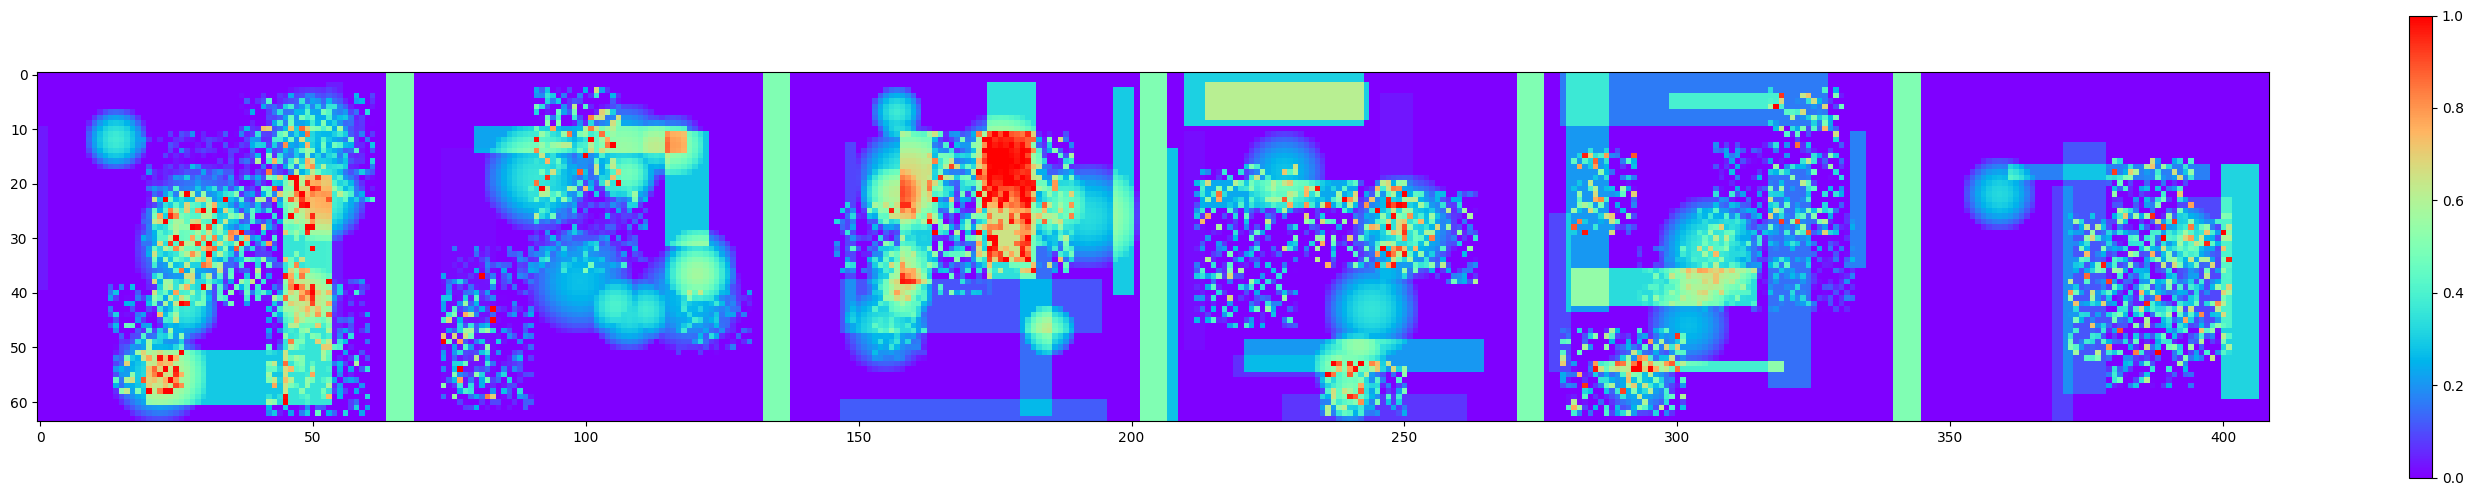

tensor([6.1231, 5.3601, 6.7716, 3.4861, 2.4145, 3.0176])


In [15]:
# sampling (x,y) :

inputs, targets = gen_ex2(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(inputs, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
print(targets)

**Q1** Définir un Loader à partir du Dataset précédent (2 workers)

In [18]:
# Créer un Dataset PyTorch
dataset = TensorDataset(inputs, targets)

# Créer un DataLoader avec 2 workers
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

**Q2** Entraîner un ResNet18 à prédire la médiane conditionnelle à l'image d'entrée. Justifier l'absence d'une étape de validation.

In [22]:
from torchvision.models import resnet18

# Charger un ResNet18 pré-entraîné
model = resnet18(pretrained=True)
# Modifier la couche de classification pour prédire une seule valeur (médiane)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50
for epoch in range(num_epochs):
       for inputs, targets in dataloader:  # dataloader défini dans la question 1
           inputs = inputs.unsqueeze(1)
           targets = targets.unsqueeze(1)
           optimizer.zero_grad()
           outputs = model(inputs)
           loss = criterion(outputs, targets)
           loss.backward()
           optimizer.step()
       print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [32, 1, 1, 64, 64]

**Q3** Modifier votre ResNet18 de manière à prédire aussi les premier et troisième quartiles. Préciser le nom de la fonction de coût utilisée.

**Q4** Après entraînement, évaluer les écarts interquartiles sur un batch de taille 64. Ces écarts semblent-ils dépendre de l'image d'entrée ?

**Q5 (Bonus)** On fait l'hypothèse que la sortie ne dépend que des disques. On suppose aussi qu'on ait accès, comme à l'exercice 1 à un jeu de données d'images ne comportant que des disques (fonction gen_d). Que feriez-vous pour tester cette hypothèse ? Répondez sans code, mais avec précision.

\

---

\

**Exercice 3** *Nettoyage et adaptation de domaine*

Comme à l'exercice 1, les disques sont considérés comme du bruit. Mais par contre, il s'agit d'une tâche de nettoyage et on se place dans le cas où des entrées et des cibles idéales sont disponibles en grand nombre à l'entraînement (fonction *gen_dr_train*).

In [ ]:
input, targets = gen_dr_train(6)
# Inputs (train)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# targets (train)
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(targets, 6, fig1, k=0, min_scale=0,max_scale=1)

Par contre, on suppose que les images disponibles à l'entraînement ne suivent pas les mêmes statistiques que les données test, échantillonnables avec la fonction gen_dr_test suivante :

In [ ]:
input, targets = gen_dr_test(6)
# Inputs (test)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# targets (test)
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(targets, 6, fig1, k=0, min_scale=0,max_scale=1)

Ce qu'on voit en effet, c'est que les images test sont plus chargées en figures géométriques. \
Dans la réalité, ce cas de figure se présente lorsque :
 - les données propres au test (ie, représentatives des données à traiter en inférence) sont en trop petit nombre pour être exploitées à l'entraînement
 - un large jeu de données dont les statistiques sont différentes de celles des données d'inférence est disponible.

**Q1** A l'aide d'internet, décrire ce que recouvre le mot clef "domain adaptation" et faites le lien avec l'énoncé.

**Q2** Sur des entraînements courts (20 - 40 époques) avec des UNet, évaluer l'impact sur les performances sur le jeu de test lorsque les données sont entraînées avec gen_dr_train plutôt que dans une situation idéale.

**Q3 (Bonus)** Proposez une méthode simple pour améliorer les performances.

\

---

\

**Exercice 4** Un article important

Parcourir rapidement l'article : https://arxiv.org/abs/1505.04597.
Préciser :
- la nature du problème de Machine Learning abordé.
- quelles méthodes d'augmentation de données sont utilisées.
- l'origine du déséquilibre entre les classes cibles et la façon dont elle il est traité (de manière synthétique).

**Reponse:**
- Il s'agit d'un problème de segmentation sémantique où chaque pixel d'une image doit être classé en fonction de sa catégorie.
- Les méthodes d'augementation de données utilisées sont : Les déformations élastiques aléatoires, les décalages et les rotations aléatoires, les variations des niveaux de gris et le Dropout.
- Le déséquilibre des classes provient du fait que, dans les images biomédicales, certaines structures (par exemple, les membranes cellulaires) occupent une proportion bien plus faible que les autres régions (cytoplasme, fond, etc.).